In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Linear regression library
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Pytorch for neural network
import torch.nn as nn
import torch.nn.functional as F
import torch


# Path to files
merged_trades = '../data/processed/merged_trades'

# Construct Training and Testing Data

In [2]:
# Load the data
folders = os.listdir(merged_trades)

# Creating array to store explanatory and predicted variables
X = None
y = None

# Going through all stocks
for stock in folders:
    # Get all fCMiles
    files = os.listdir(f'{merged_trades}/{stock}')

    # Load prices and volumes
    df_prices = pd.read_parquet(f'{merged_trades}/{stock}/{stock}_prices.parquet')
    df_volumes = pd.read_parquet(f'{merged_trades}/{stock}/{stock}_volumes.parquet')

    # Working with arrays
    prices = df_prices.values
    volumes = df_volumes.values

    # Compute returns and relative volumes
    returns = prices[1:] / prices[:-1] - 1
    rel_volumes = volumes / np.cumsum(volumes, axis=0)

    # Remove rows and transpose
    returns = returns.T
    rel_volumes = rel_volumes[1:-1].T

    # Combine returns and relative volumes to create 3D array
    X_stock = np.stack((returns[:, :-1], rel_volumes), axis=2)
    y_stock = returns[:, -1]

    # Add to the main array
    if X is None:
        X = X_stock
        y = y_stock
    else:
        X = np.concatenate((X, X_stock))
        y = np.concatenate((y, y_stock))


# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Linear Regression

In [31]:
df = pd.DataFrame(columns=['mae', 'accuracy'])
for i in range(X_train.shape[1]):
    # Create the model
    model = LinearRegression()

    # Removal of features
    if i == 0:
        X_train_ = X_train[:, :, 0]
        X_test_ = X_test[:, :, 0]
    else:
        X_train_ = X_train[:, :-i, 0]
        X_test_ = X_test[:, :-i, 0]

    # Fitting the model
    model.fit(X_train_, y_train)

    # Predictions
    y_pred = model.predict(X_test_)
    mae = mean_absolute_error(y_test, y_pred)
    acc = np.sum((np.sign(y_pred) == np.sign(y_test))) / len(y_test)

    # Store the results
    df.loc[i+1] = [mae, acc]

df.to_csv('../results/linear_regression.csv', index=False)

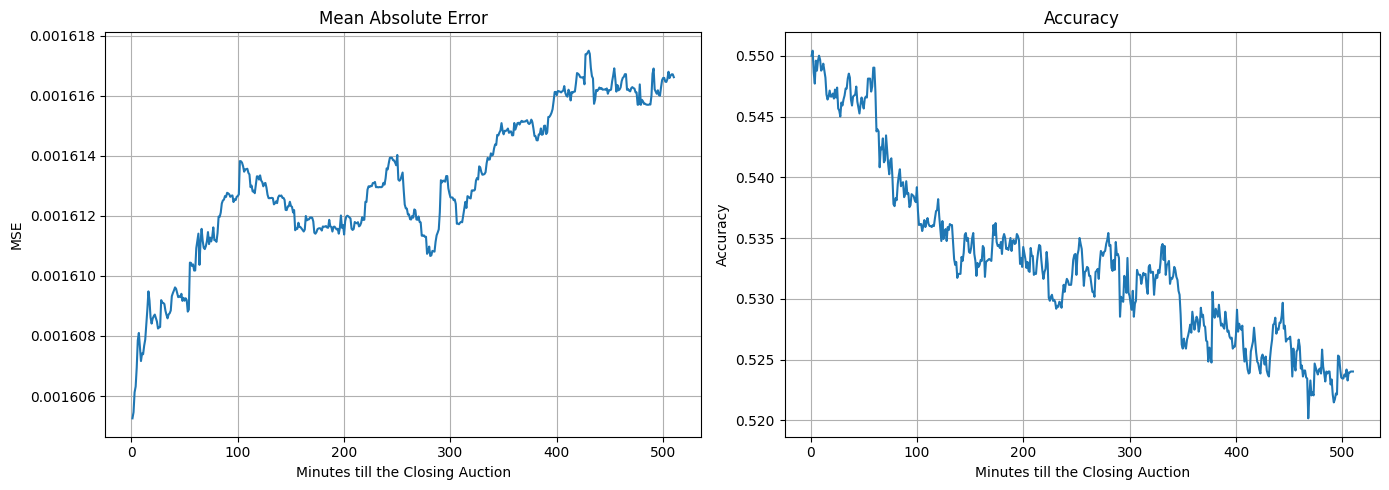

In [34]:
df = pd.read_csv('../results/linear_regression.csv')

# Unpack to mae and accuracy
mae_errs = df['mae'].values
acc = df['accuracy'].values

# Create figure
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# X axis
x = np.arange(1, len(mae_errs)+1)

# Plotting Mean Absolute Error
ax[0].plot(x, mae_errs)
ax[0].set_title('Mean Absolute Error')
ax[0].set_xlabel('Minutes till the Closing Auction')
ax[0].set_ylabel('MSE')

# Plotting accuracy
ax[1].plot(x, acc)
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Minutes till the Closing Auction')
ax[1].set_ylabel('Accuracy')

# Settings for both plots
for i in range(2):
    ax[i].grid()
fig.tight_layout()
# Saving
plt.savefig('../figures/linear_regression.png')